<b>

<p>
<center>
<font size="5">
Final Project (DATS 6202 - O10), Spring 2019
</font>
</center>
</p>

<p>
<center>
<font size="4">
Earthquake Prediction
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size="3">
Author: Elie Tetteh-Wayoe, Mihir Gadgil and Poornima Joshi
</font>
</center>
</p>

</b>

## Introduction

Problem and Motivation:

Forecasting earthquakes is one of the most important challenges in Earth science because
of their devastating consequences. Current scientific studies related to earthquake
forecasting focus on three key points: when the event will occur, where it will occur, and how
large it will be. Los Alamos National Laboratory is hosting a Kaggle competition to further
this research.

In this competition, the aim is to address when the earthquake will take place. Specifically,
predict the time remaining before laboratory earthquakes occur from real-time seismic data.
The challenge is that the data has only one feature and target to work with. The
‘acoustic_data’ is the feature and ‘time_to_failure’ is the target. Creating multiple sensible
features from the available data will be a core part of the project.

If this challenge is solved and the physics are ultimately shown to scale from the laboratory
to the field, researchers will have the potential to improve earthquake hazard assessments
that could save lives and billions of dollars in infrastructure.

## Experiment

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from os import listdir
from os.path import isfile
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasRegressor

# Set Pandas precision
pd.set_option('display.precision', 9)

In [2]:
import warnings
warnings.filterwarnings('ignore')

### EDA

In [5]:
# What kind of data do we have
print(os.listdir("../Earthquake-Predictions/data/"))

['.DS_Store', 'test', 'LANL-Earthquake-Prediction.zip', 'test.zip', '.gitignore', 'train.csv', 'sample_submission.csv']


In [6]:
# How does the data look like 

z = pd.read_csv("data/train.csv", nrows=5)
print("The data looks like this :")
z.head()

The data looks like this :


,acoustic_data,time_to_failure
0,12,1.469099983
1,6,1.469099982
2,8,1.469099981
3,5,1.469099980
4,8,1.469099979


In [7]:
# Look at how big our data is
df_length = 0
for training in pd.read_csv('data/train.csv', chunksize=150000):
    df_length = df_length + len(training)
    
print("Train has: rows: {} ".format(df_length))

# It has 629,145,480 number of rows

Train has: rows: 629145480 


We have one long array of seismic data. We will break it down into chunks of size 150k (chunk) and each chunk will be one signal in our data (this is because each segment in the test data has length 150k). The time_to_failure at the last time step of each segment becomes the target associated with that segment.

In [4]:
%%time
df_train = pd.DataFrame(columns=['acoustic_data', 'time_to_failure'], dtype=np.float)

for train in pd.read_csv('data/train.csv', chunksize=150000):
    df_train = df_train.append(train[::50])
    
#     np.append(train_acoustic_data_small, train['acoustic_data'].values[::50])
#     np.append(train_time_to_failure_small, train['time_to_failure'].values[::50])


CPU times: user 12min 52s, sys: 9min 9s, total: 22min 2s
Wall time: 22min 10s


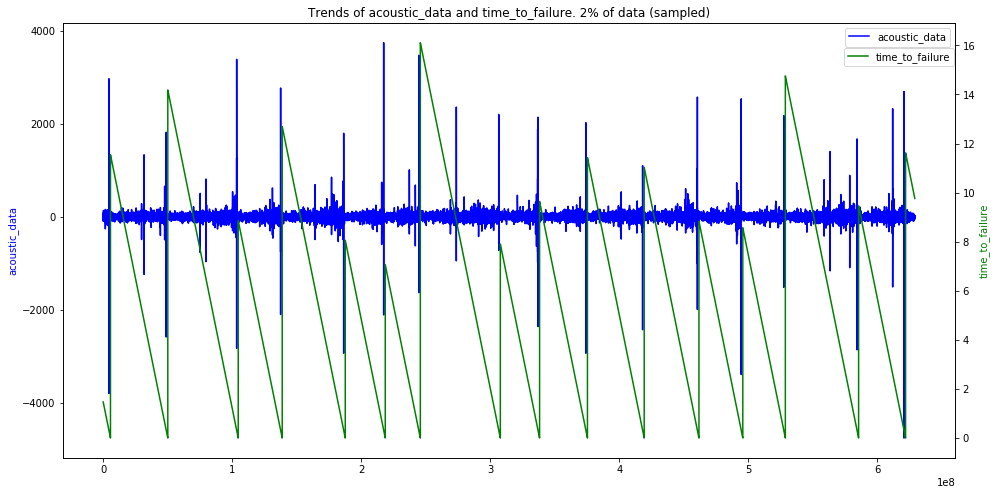

In [5]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(df_train['acoustic_data'], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(df_train['time_to_failure'], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

Extracting features from each part of the segment

The original long seismic signal has been broken down into several more features. Usually features such as mean, standard deviation, range, percentiles etc are calculated over each part of the chunk and each part of the chunk is represented by its own list of such features.

In [3]:
# Creating more features from the existing data
n = 150_000
freq = 500
columns = [
    'mean', 'std', 'min', 'max', 'sum', 'abs_mean', 'abs_std', 'abs_max', 'abs_sum', 'argmax', 'rate_mean', 'rate_std',
    'rate_max', 'rate_min', 'rate_abs_max'
]

columns.extend(['fftr' + str(i) for i in range(0, freq)])
columns.extend(['fftr' + str(i) for i in range(n//2 - freq, n//2 + freq)])
columns.extend(['fftr' + str(i) for i in range(n-freq, n)])
columns.extend(['ffti' + str(i) for i in range(0, freq)])
columns.extend(['ffti' + str(i) for i in range(n//2 - freq, n//2 + freq)])
columns.extend(['ffti' + str(i) for i in range(n-freq, n)])

roll_windows = [100, 500, 1000, 2000, 4000, 10000]
columns.extend(['rolling_mean_' + str(i) for i in roll_windows])
columns.extend(['rolling_std_' + str(i) for i in roll_windows])

df_train = pd.DataFrame(dtype=np.float, columns=columns)

In [4]:
def generate_features(chunk):
    mean = chunk['acoustic_data'].mean()
    std = chunk['acoustic_data'].std()
    min = chunk['acoustic_data'].min()
    max = chunk['acoustic_data'].max()
    sum = chunk['acoustic_data'].sum()
    abs_sum = chunk['acoustic_data'].abs().sum()
    abs_max = chunk['acoustic_data'].abs().max()
    abs_mean = chunk['acoustic_data'].abs().mean()
    abs_std = chunk['acoustic_data'].abs().std()
    argmax = chunk['acoustic_data'].abs().values.argmax()
    rate = np.diff(chunk['acoustic_data'].values)
    rate_mean = rate.mean()
    rate_std = rate.std()
    rate_max = rate.max()
    rate_min = rate.min()
    rate_abs_max = np.abs(rate).max()
    fft = np.fft.fft(chunk['acoustic_data'], n=n)
    result = [
        mean, std, min, max, sum, abs_mean, abs_std, abs_max, abs_sum, argmax, rate_mean, rate_std, rate_max, rate_min,
        rate_abs_max
    ]
    result.extend(list(fft.real[0:freq]))
    result.extend(list(fft.real[n//2-freq:n//2+freq]))
    result.extend(list(fft.real[n-freq:n]))
    result.extend(list(fft.imag[0:freq]))
    result.extend(list(fft.imag[n//2-freq:n//2+freq]))
    result.extend(list(fft.imag[n-freq:n]))
    for window in roll_windows:
        result.append(
            chunk['acoustic_data'].rolling(window=window).mean().mean(skipna=True)
        )
        result.append(
            chunk['acoustic_data'].rolling(window=window).std().mean(skipna=True)
        )
    return result

In [5]:
i = 0
for chunk in pd.read_csv('train.csv', chunksize=n):
    df_train.loc[i, columns] = generate_features(chunk)
    df_train.loc[i, 'time_to_failure'] = chunk['time_to_failure'].values[-1]
    i += 1

In [8]:
df_train.describe()

,mean,std,min,max,sum,abs_mean,abs_std,abs_max,abs_sum,argmax,...,rolling_mean_2000,rolling_mean_4000,rolling_mean_10000,rolling_std_100,rolling_std_500,rolling_std_1000,rolling_std_2000,rolling_std_4000,rolling_std_10000,time_to_failure
count,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4.195000000e+03,4195.000000000,...,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000
mean,4.519475158,6.547788191,-149.190941597,163.522288439,677807.531823599,5.547366504,5.750164895,170.046245530,8.319850017e+05,75732.748748510,...,4.494530245,4.519455817,4.651122824,4.519434433,4.875305718,4.519406578,5.147596567,4.519440725,5.534768028,5.683670383
std,0.256049486,8.503939490,265.087983548,272.930331447,39087.639872457,1.517037556,8.339211436,296.887014915,2.277461406e+05,43215.786643884,...,2.100400425,0.256133707,2.204306437,0.256222511,2.393564200,0.256388311,2.723462863,0.256914819,3.492272857,3.673246303
min,3.596313333,2.802720142,-5515.000000000,23.000000000,207622.000000000,4.147706667,2.589085218,23.000000000,2.189980000e+05,32.000000000,...,2.763978830,3.596077322,2.773865037,3.596091178,2.782937017,3.594675703,2.790480525,3.596157421,2.795723461,0.006397657
25%,4.349496667,4.478637142,-154.000000000,92.000000000,652414.000000000,5.061843333,3.862810034,94.000000000,7.592765000e+05,38923.000000000,...,3.608049516,4.349204827,3.692809198,4.349688480,3.822511676,4.350300757,3.969471868,4.350899598,4.154359407,2.635348205
50%,4.522146667,5.618797775,-111.000000000,123.000000000,678274.000000000,5.380853333,4.781513433,127.000000000,8.071280000e+05,76146.000000000,...,4.290168141,4.521862665,4.429379855,4.521381707,4.621979719,4.522010216,4.857082991,4.522608771,5.141857763,5.358795935
75%,4.693350000,6.880903553,-79.000000000,170.000000000,704002.500000000,5.748553333,5.887947258,175.000000000,8.622830000e+05,112417.500000000,...,4.944028752,4.693063728,5.140581035,4.693345636,5.419183066,4.693747711,5.746768467,4.693672359,6.171136010,8.177499733
max,5.391993333,153.703569356,-15.000000000,5444.000000000,808799.000000000,32.762073333,150.432368254,5515.000000000,4.914311000e+06,149985.000000000,...,40.833016217,5.392530339,42.577828502,5.391952193,46.048275306,5.390577464,52.659806087,5.382573062,68.680476387,16.103195567


In [25]:
df_train.head()

,mean,std,min,max,sum,abs_mean,abs_std,abs_max,abs_sum,argmax,...,rolling_mean_2000,rolling_mean_4000,rolling_mean_10000,rolling_std_100,rolling_std_500,rolling_std_1000,rolling_std_2000,rolling_std_4000,rolling_std_10000,time_to_failure
0,4.884113333,5.101106131,-98.0,104.0,732617.0,5.576566667,4.333324674,104.0,836485.0,2592.0,...,4.182269694,4.883418266,4.288590311,4.881665249,4.411259502,4.879250551,4.460670633,4.876886100,4.431413244,1.430797186
1,4.725766667,6.588823782,-154.0,181.0,708865.0,5.734166667,5.732776966,181.0,860125.0,11860.0,...,4.653421355,4.724876383,4.843485536,4.724689860,5.116232929,4.721938879,5.476469293,4.713898269,6.046480431,1.391498893
2,4.906393333,6.967397034,-106.0,140.0,735959.0,6.152646667,5.895944714,140.0,922897.0,129279.0,...,5.178792262,4.905839578,5.423012904,4.906173495,5.774157759,4.904014151,6.125550607,4.901086207,6.324556488,1.353196095
3,4.902240000,6.922305187,-199.0,197.0,735336.0,5.933960000,6.061213600,199.0,890094.0,67060.0,...,4.743548231,4.901486292,4.939280458,4.901312417,5.226714645,4.899401829,5.569334638,4.890118824,6.102269867,1.313797802
4,4.908720000,7.301110190,-126.0,145.0,736308.0,6.110586667,6.329485314,145.0,916588.0,80896.0,...,4.950485374,4.910195703,5.121868457,4.910102418,5.377340466,4.909516745,5.770087321,4.912307696,6.314026153,1.274399509


In [9]:
# Check if any nan values are generated
df_train.isna().sum()

mean                  0
std                   0
min                   0
max                   0
sum                   0
abs_mean              0
abs_std               0
abs_max               0
abs_sum               0
argmax                0
rate_mean             0
rate_std              0
rate_max              0
rate_min              0
rate_abs_max          0
fftr0                 0
fftr1                 0
fftr2                 0
fftr3                 0
fftr4                 0
fftr5                 0
fftr6                 0
fftr7                 0
fftr8                 0
fftr9                 0
fftr10                0
fftr11                0
fftr12                0
fftr13                0
fftr14                0
                     ..
ffti149983            0
ffti149984            0
ffti149985            0
ffti149986            0
ffti149987            0
ffti149988            0
ffti149989            0
ffti149990            0
ffti149991            0
ffti149992            0
ffti149993      

In [6]:
# Seperate the data into X_train and Y_train

X_train = df_train.drop(columns=['time_to_failure']).values
y_train = df_train['time_to_failure'].values

### Feature Engineering

Since the data we use here has only one feature to use for learning and the data set is fairly huge to work with, it is important to capture the essence of the data. Thus, we are generating more features using the exsisting data by using methods like calulating mean, standard deviation, rolling statistics etc.

Further, to choose the best features that contribute significantly to model, we build a random forest regressor in order to identify the top contributing features.

In [7]:
# Choosing the best contributing features using random forest regressor
rfr = RandomForestRegressor(n_estimators=500, random_state=0, n_jobs=-1)
pipe_rfr = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestRegressor', rfr)])

In [8]:
# Calling fit on the random forest regressor
pipe_rfr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [9]:
# Creating a dataframe to choose the best features
features = pd.DataFrame({'Feature': columns, 'Importance': rfr.feature_importances_, 'Correlation': df_train.drop(columns='time_to_failure').corrwith(df_train['time_to_failure']).abs().values})

In [10]:
# Sorting the features in descending order so we choose the best one
features = features.sort_values(by='Importance', ascending=False)
features.head()

,Feature,Importance,Correlation
4016,rolling_mean_500,0.409480064,0.342833017
4018,rolling_mean_2000,0.016739319,0.351513349
6,abs_std,0.003146086,0.201231156
4020,rolling_mean_10000,0.002197235,0.358516850
4025,rolling_std_4000,0.002072427,0.031354446


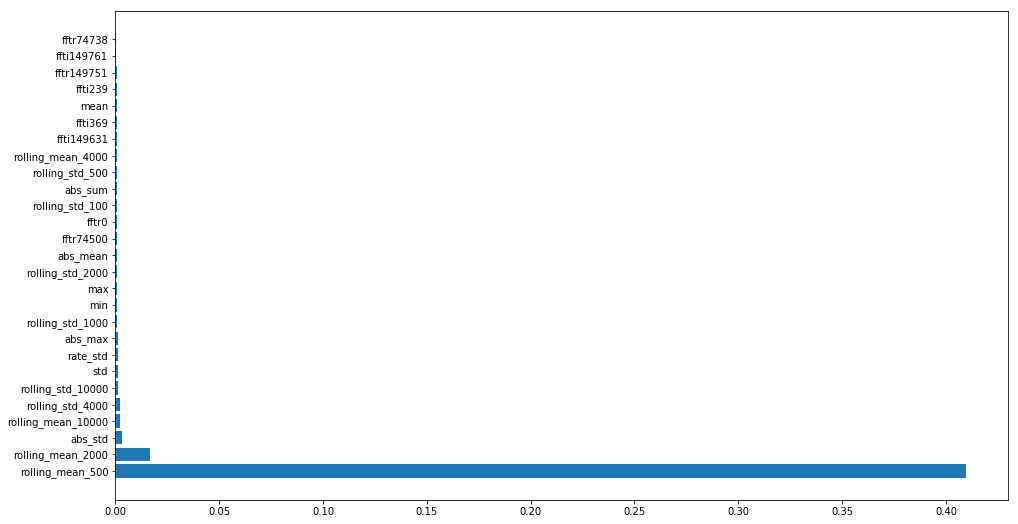

In [11]:
# Visualizing the best performing feature from the 'features' dataframe
plt.figure(figsize=(16, 9))
plt.barh(y='Feature', width='Importance', data=features[:27])
plt.show()

In [12]:
# Subsetting the top 27 features
n_features = 27
X_train = df_train[features['Feature'][:n_features]].values
y_train = df_train['time_to_failure'].values

In [13]:
# Traverse through the test directory
path = 'test/'
files = [f[:-4] for f in listdir(path) if isfile(path + f)]

In [14]:
# Prepare as submission data frame
predictions = pd.DataFrame(index=files, dtype=np.float, columns=['time_to_failure'])
predictions.index.name = 'seg_id'

### Linear Regression 
We started with simple linear regression, since that is the simplest and most straight forward method we are familiar with

In [15]:
# Prepare pipeline

pipe_linear = Pipeline([('StandardScaler', StandardScaler()), ('Linear', linear_model.LinearRegression())])

In [16]:
# Hyperparamters for the linear model

parameters_linear = [{'Linear__fit_intercept':('True', 'False'), 'Linear__normalize':('True', 'False'), 'Linear__copy_X':('True', 'False')}]

In [17]:
# Perform grid search CV on with different parameters

gs_linear = GridSearchCV(
    estimator=pipe_linear,
    param_grid=parameters_linear,
    iid=False,
    n_jobs=-1,
    cv = KFold(
        n_splits=10,
        shuffle=True,
        random_state=0
    )
)

gs_linear.fit(X_train, y_train)
print('Best score:', gs_linear.best_score_)
print('Best hyperparameters:', gs_linear.best_params_)

Best score: 0.39180189723712994
Best hyperparameters: {'Linear__copy_X': 'True', 'Linear__fit_intercept': 'True', 'Linear__normalize': 'True'}


### Elastic Net
To improve the Linear regression results, we used a penalised method like Elastic search. As we can notice, we got slightly better results

In [18]:
# Prepare pipeline

pipe_elastic = Pipeline([('StandardScaler', StandardScaler()), ('ElasticNet', ElasticNet(random_state=0))])

In [19]:
# Hyperparamters for the elasticnet model

param_grid_elastic = [{"ElasticNet__max_iter": [1, 5, 10], "ElasticNet__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], "ElasticNet__l1_ratio": np.arange(0.0, 1.0, 0.1)}]


In [20]:
# Perform grid search CV on with different parameters
gs_elastic = GridSearchCV(
    estimator=pipe_elastic,
    param_grid=param_grid_elastic,
    iid=False,
    n_jobs=-1,
    cv = KFold(
        n_splits=10,
        shuffle=True,
        random_state=0
    )
)

gs_elastic.fit(X_train, y_train)
print('Best score:', gs_elastic.best_score_)
print('Best hyperparameters:', gs_elastic.best_params_)

Best score: 0.3364231269074221
Best hyperparameters: {'ElasticNet__alpha': 0.0001, 'ElasticNet__l1_ratio': 0.9, 'ElasticNet__max_iter': 10}


### Neural Network

The next model we are trying is neural network. Earthquakes are a complicated phenomenon, so we expect a neural network to be better at capturing the non-linearity and perform better than linear regression.

We are using the top 27 features ranked by importance, so we search through a grid of different hidden layer numbers and sizes. The other hyperparameters being tuned are the learning rate, regularization parameter and the tolerance for cross validation score stopping.

In [21]:
# Prepare Pipeline

pipe_nn = Pipeline([('StandardScaler', StandardScaler()), ('Regressor', MLPRegressor(random_state=0))])

In [22]:
# Hyperparamters for the neural network model

param_grid_nn = [{
    'Regressor__hidden_layer_sizes': [(18), (18, 12), (18, 12, 8)],
    'Regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'Regressor__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'Regressor__tol': [0.0001, 0.001, 0.01]
}]

In [23]:
# Perform grid search CV on with different parameters

gs_nn = GridSearchCV(
    estimator=pipe_nn,
    param_grid=param_grid_nn,
    iid=False,
    n_jobs=-1,
    cv = KFold(
        n_splits=10,
        shuffle=True,
        random_state=0
    )
)

gs_nn.fit(X_train, y_train)
print('Best score:', gs_nn.best_score_)
print('Best hyperparameters:', gs_nn.best_params_)

Best score: 0.4384087789358146
Best hyperparameters: {'Regressor__alpha': 0.01, 'Regressor__hidden_layer_sizes': 18, 'Regressor__learning_rate_init': 0.1, 'Regressor__tol': 0.01}


In [24]:
# Make a predictions empty dataframe to use later on

predictions = pd.DataFrame(index=files, dtype=np.float, columns=['time_to_failure'])
predictions.index.name = 'seg_id'

In [25]:
# For all files in the test folder, run predict function and add to 'predictions' dataframe

for f in files:
    if f.startswith("seg_"):
        df = pd.read_csv(path+f+'.csv')
        df_test = pd.DataFrame(np.array(generate_features(df)).reshape(1,-1), columns=columns)
        X_test = df_test[features['Feature'][:n_features]].values
        y = gs_nn.predict(X_test)[0]
        predictions.loc[f, 'time_to_failure'] = y

In [26]:
# Export the predictions dataframe to a csv

predictions.to_csv('submission.csv')

In [27]:
# Peek at the predictions

predictions.head()

,time_to_failure
seg_id,
seg_51f0a2,3.313018567
seg_de98fa,3.353641289
seg_ad82ca,5.807332119
seg_e3ca24,5.977805806
seg_64f8dc,4.180987860


### Neural Network using tensorflow

In [29]:
# Create function returning a compiled network
def kerasModel(optimizer, metrics, loss, activation, input_shape= X_train.shape[1]):
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=input_shape, activation=activation, input_dim=input_shape))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units= int(input_shape/2), activation=activation))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1))

    # Compile neural network
    network.compile(loss=loss, # Cross-entropy
                    optimizer=optimizer, # Optimizer
                    metrics=[metrics]) # Accuracy performance metric
    
    # Return compiled network
    return network

In [30]:
KModel = KerasRegressor(build_fn=kerasModel, verbose=0)

In [31]:
# Create hyperparameter space
epochs = [50 , 100]
batches = [50, 100]
optimizer = ['adam','sgd']
loss= ['mse','mae']
activation = ['relu', 'exponential']
metrics = ['mse','mae']

# Create hyperparameter options
hyperparameters = dict(Model__optimizer=optimizer, Model__loss = loss, Model__epochs=epochs, Model__batch_size=batches, Model__activation= activation,
                            Model__metrics = metrics)

In [32]:
pipe_keras = Pipeline([('StandardScaler', StandardScaler()), ('Model', KModel)])

In [33]:
gs_keras = GridSearchCV(
    estimator=pipe_keras,
    param_grid=hyperparameters,
    iid = False,
    n_jobs=-1,
    cv = KFold(
        n_splits=10,
        shuffle=True,
        random_state=0
    )
)

gs_keras.fit(X_train, y_train)
print('Best score:', gs_keras.best_score_)
print('Best hyperparameters:', gs_keras.best_params_)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Best score: -2.1161506966347448
Best hyperparameters: {'Model__activation': 'relu', 'Model__batch_size': 50, 'Model__epochs': 100, 'Model__loss': 'mae', 'Model__metrics': 'mae', 'Model__optimizer': 'adam'}


In [34]:
# Make a predictions empty dataframe to use later on

predictions_Keras = pd.DataFrame(index=files, dtype=np.float, columns=['time_to_failure'])
predictions_Keras.index.name = 'seg_id'

In [35]:
# For all files in the test folder, run predict function and add to 'predictions' dataframe

for f in files:
    if f.startswith("seg_"):
        df = pd.read_csv(path+f+'.csv')
        df_test = pd.DataFrame(np.array(generate_features(df)).reshape(1,-1), columns=columns)
        X_test = df_test[features['Feature'][:n_features]].values
        y = gs_nn.predict(X_test)[0]
        predictions_Keras.loc[f, 'time_to_failure'] = y

In [36]:
# Peek at the predictions

predictions_Keras.head()

,time_to_failure
seg_id,
seg_51f0a2,3.313018567
seg_de98fa,3.353641289
seg_ad82ca,5.807332119
seg_e3ca24,5.977805806
seg_64f8dc,4.180987860


In [37]:
# Export the predictions dataframe to a csv

predictions_Keras.to_csv('submission_Keras.csv')

### Conclusion

Based on the cross validation score, we expect Neural Network with 1 input layer, 1 hidden layer with 18 nodes and 1 output layer to give us the best R<sup>2</sup> coefficient. 

Another important observation we can make in this experiment is that, the performance of the model is highly correlated with the features used. As we can see in the graph, rolling_mean_500 has an importance value of 0.41, followed by  rolling_mean_2000 with an importance value of 0.01. We can see a strike difference in the performance of the features.

In conclusion, Neural Network is the best model for this data. More importantly, efficient feature engineering is the key to building a good model.

### References

- https://kaggle.com/c/LANL-Earthquake-Prediction/discussion
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
